# Northwind Tests

## Introduction

## Discount Effect
Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

Tables needed:
- Orders
- Order Details
- Products
- Customer

In [224]:
# Imports
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect
import pandas as pd
import numpy as np
import scipy.stats as stats
import random
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Connect to database
engine = create_engine("sqlite:///Northwind_small.sqlite", echo=True)
Session = sessionmaker(bind=engine)
session = Session()

In [225]:
# Use inspect to check database metadata against the ERD we have of the database
inspector = inspect(engine)
table_names = inspector.get_table_names()
print(table_names)

2019-06-06 11:00:48,465 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-06-06 11:00:48,466 INFO sqlalchemy.engine.base.Engine ()
2019-06-06 11:00:48,468 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-06-06 11:00:48,469 INFO sqlalchemy.engine.base.Engine ()
2019-06-06 11:00:48,471 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-06-06 11:00:48,472 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


### Get Data

Our first step is to query our database for the tables we might need and save the data into a pandas.DataFrames to work with. At this point we will see which of the tables will be necessary for us to gather the data we need to answer our business questions

In [226]:
# I created a couple of functions to make it easier to inspect and retreive necessary data

def get_columns_info(table_name):
    """ Print the name and type of each column in the given table.
    
    Args:
        table_name: Name of the table (string)
    """
    cols_list = inspector.get_columns(table_name)
    
    print("Table Name: {}".format(table_name))
    print("")
    for column in cols_list:
        print("Name: {}, \t {}".format(column['name'], column['type']))


def get_column_names(table_name):
    """ Get the name of each column in the given table.
    
    Args:
        table_name: Name of the table (string)
    
    Returns:
        A list of column names
    """
    cols_list = inspector.get_columns(table_name)
    col_names = []
    for column in cols_list:
        col_names.append(column['name'])
    return col_names

get_columns_info('Employee')

2019-06-06 11:00:48,491 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Employee")
2019-06-06 11:00:48,493 INFO sqlalchemy.engine.base.Engine ()
Table Name: Employee

Name: Id, 	 INTEGER
Name: LastName, 	 VARCHAR(8000)
Name: FirstName, 	 VARCHAR(8000)
Name: Title, 	 VARCHAR(8000)
Name: TitleOfCourtesy, 	 VARCHAR(8000)
Name: BirthDate, 	 VARCHAR(8000)
Name: HireDate, 	 VARCHAR(8000)
Name: Address, 	 VARCHAR(8000)
Name: City, 	 VARCHAR(8000)
Name: Region, 	 VARCHAR(8000)
Name: PostalCode, 	 VARCHAR(8000)
Name: Country, 	 VARCHAR(8000)
Name: HomePhone, 	 VARCHAR(8000)
Name: Extension, 	 VARCHAR(8000)
Name: Photo, 	 BLOB
Name: Notes, 	 VARCHAR(8000)
Name: ReportsTo, 	 INTEGER
Name: PhotoPath, 	 VARCHAR(8000)


In [227]:
con = engine.connect()

### Explore and Clean

In [228]:
def get_table_data(con, table_name):
    """Get the data from the given table
    
    Args:
        con: Database connection
        table_name: Name of the table (string)
    
    Returns:
        Pandas Dataframe with the data from the table
    """
    table = con.execute("SELECT * FROM '{}'".format(table_name))
    table_df = pd.DataFrame(table.fetchall())
    col = get_column_names('{}'.format(table_name))
    table_df.columns = col
    return table_df


products_df = get_table_data(con, 'Product')
details_df = get_table_data(con, 'OrderDetail')
orders_df = get_table_data(con, 'Order')

products_df.head()

2019-06-06 11:00:48,518 INFO sqlalchemy.engine.base.Engine SELECT * FROM 'Product'
2019-06-06 11:00:48,520 INFO sqlalchemy.engine.base.Engine ()
2019-06-06 11:00:48,523 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Product")
2019-06-06 11:00:48,524 INFO sqlalchemy.engine.base.Engine ()
2019-06-06 11:00:48,526 INFO sqlalchemy.engine.base.Engine SELECT * FROM 'OrderDetail'
2019-06-06 11:00:48,527 INFO sqlalchemy.engine.base.Engine ()
2019-06-06 11:00:48,536 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("OrderDetail")
2019-06-06 11:00:48,537 INFO sqlalchemy.engine.base.Engine ()
2019-06-06 11:00:48,539 INFO sqlalchemy.engine.base.Engine SELECT * FROM 'Order'
2019-06-06 11:00:48,540 INFO sqlalchemy.engine.base.Engine ()
2019-06-06 11:00:48,548 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Order")
2019-06-06 11:00:48,549 INFO sqlalchemy.engine.base.Engine ()


,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


In [229]:
print(details_df.loc[details_df['OrderId'] == 10249])
print(details_df.loc[details_df['ProductId'] == 5])

         Id  OrderId  ProductId  UnitPrice  Quantity  Discount
3  10249/14    10249         14       18.6         9       0.0
4  10249/51    10249         51       42.4        40       0.0
           Id  OrderId  ProductId  UnitPrice  Quantity  Discount
30    10258/5    10258          5      17.00        65      0.20
40    10262/5    10262          5      17.00        12      0.20
111   10290/5    10290          5      17.00        20      0.00
352   10382/5    10382          5      17.00        32      0.00
1022  10635/5    10635          5      21.35        15      0.10
1212  10708/5    10708          5      21.35         4      0.00
1575  10848/5    10848          5      21.35        30      0.00
1840  10958/5    10958          5      21.35        20      0.00
2018  11030/5    11030          5      21.35        70      0.00
2061  11047/5    11047          5      21.35        30      0.25


Filtering details_df by OrderId shows that each record in the `OrderDetail` table describes one product within one order. So, each observation in `Order` table will have one or more observations in the `OrderDetail` table. This means we don't need the `Orders` table as it mainly describes details about the shippment and not what's in the order. 

When looking at all the observations of the same product in the `OrderDetail` table shows that the company didn't always use the price listed in the `Product` table's `UnitPrice`. The quantities and discount levels don't seem to be causing the difference and it's not the average price. So we'll assume the `Product` table's `UnitPrice` to be the suggested price and therefore isn't relevant for what we're trying to acomplish.

This just leaves us with the `OrderDetail` table. We'll drop the columns we won't need to clean up the DataFrame.

In [230]:
df = details_df.drop(['Id'], axis=1)
df.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248,11,14.0,12,0.0
1,10248,42,9.8,10,0.0
2,10248,72,34.8,5,0.0
3,10249,14,18.6,9,0.0
4,10249,51,42.4,40,0.0


In [231]:
df['ProductId'].value_counts()
df['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

**Scrub Data**

Looking at the values we have in each column, there are some discount values that don't have enough observations to make any statistical inferences. We'll drop all rows that contain the following values:
- 0.01
- 0.02
- 0.03
- 0.04
- 0.06

In [232]:
drop_list = [0.01, 0.02, 0.03, 0.04, 0.06]
df = df[~df['Discount'].isin(drop_list) ]
df['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

### Experimental Design

**Normality**

**Independence**

**Random**

#### Get Samples

In [233]:
treatment = df.loc[df['Discount'] != 0]
control = df.loc[df['Discount'] == 0]
treatment['Discount'].value_counts()
treatment.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount
6,10250,51,42.4,35,0.15
7,10250,65,16.8,15,0.15
8,10251,22,16.8,6,0.05
9,10251,57,15.6,15,0.05
11,10252,20,64.8,40,0.05


Text(0, 0.5, 'Proportion')

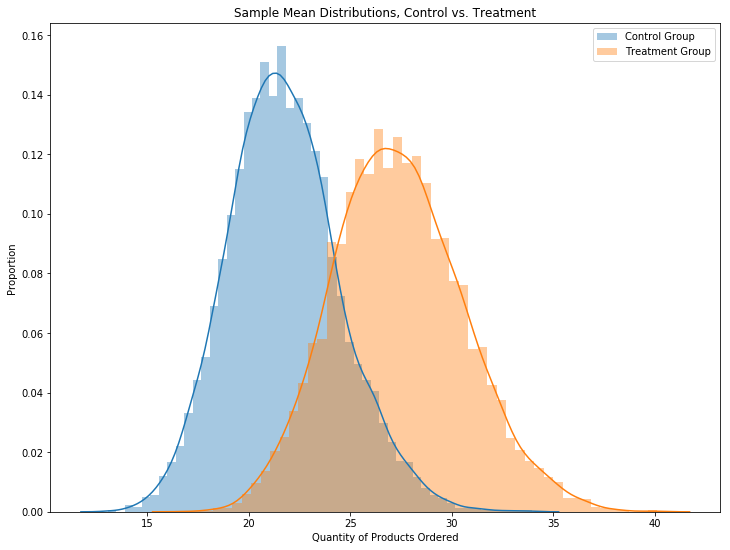

In [234]:
def get_pop_mean(group, size=10000):
    """Get the population mean by using the central limit theorem
    
    Args:
        group: (pd.Series) observations, must be numerical
        size: (int) size of distribution
    
    Returns:
        float: population mean
    """
    xbars = []
    for i in range(size):
        xbars.append(np.mean(group.sample(n=40)))
    return xbars

control_quantity_dist = get_pop_mean(control.Quantity)
treatment_quantity_dist = get_pop_mean(treatment.Quantity)

plt.figure(figsize=(12,9))
sns.distplot(control_quantity_dist, label='Control Group')
sns.distplot(treatment_quantity_dist, label='Treatment Group')
plt.legend()
plt.title('Sample Mean Distributions, Control vs. Treatment')
plt.xlabel('Quantity of Products Ordered')
plt.ylabel('Proportion')

Visually inspecting the population mean distributions, the discounted group looks different from the control group but there is a fair amount of overlap between the two.

#### T Test

To make sure our two groups have a statistically significant difference, we'll run a t-test using the stats library.

**Form Hypothesis**

Now that we have our treament and control datasets, we can execute our hypothesis test.

$H_o: \mu_t = \mu_c$

$H_a: \mu_t > \mu_c$

$\alpha$ = 0.05

**Conduct Experiment**

We'll take a sample from our control and treatment groups and run a one-sided, two-sample hypothesis test with an alpha level of 0.05.

In [235]:
sample_t = pd.DataFrame(treatment_quantity_dist).sample(n = 50, random_state=10)
sample_c = pd.DataFrame(control_quantity_dist).sample(n = 50, random_state=10)
results = stats.ttest_rel(sample_t, sample_c)
alpha = 0.05
if (results[0] > 0) & (results[1]/2 < alpha):
    print("reject null hypothesis, mean of {} is greater than mean of {}".format('Discounted Quantities','Nondiscounted Quantities'))
else:
    print("fail to reject null hypothesis")

reject null hypothesis, mean of Discounted Quantities is greater than mean of Nondiscounted Quantities


#### Analyze Results
We have significant evidence to reject the null hypothsis that the mean quanitites of discount orders is equal to the mean quantities on nondiscounted orders. 

#### ANOVA
**Determine if the level of discount effects quantities purchased**

Now that we have accepted that discounts do increase the quantity of items purchased, we need to figure out at what discount level is the effect most significant. We'll start with an ANOVA test to figure out if there is a difference in effect between the different levels of discounts.


**Form Hypothesis**
$H_o: \mu_{0.05} = \mu_{0.10} = \mu_{0.15} = \mu_{0.20} = \mu_{0.25}$ 

$H_a: \mu_{0.05} != \mu_{0.10} != \mu_{0.15} != \mu_{0.20} != \mu_{0.25}$ 

**Sample Different Discount Rates**



In [236]:
five = treatment.loc[treatment['Discount'] == 0.05]
ten = treatment.loc[treatment['Discount'] == 0.10]
fifteen = treatment.loc[treatment['Discount'] == 0.15]
twenty = treatment.loc[treatment['Discount'] == 0.20]
twentyfive = treatment.loc[treatment['Discount'] == 0.25]

data = pd.DataFrame()

for group, name in [(five, '0.05'), (ten, '0.10'), (fifteen, '0.15'), (twenty, '0.20'), (twentyfive, '0.25')]:
    group = group.sample(n=50, random_state=10)
    data[name] = group.Quantity.reset_index(drop=True)
data.head()

,0.05,0.10,0.15,0.20,0.25
0,12,20,24,40,20
1,28,18,70,55,2
2,24,18,40,6,12
3,8,15,10,30,20
4,2,10,16,45,30


/Users/joe/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


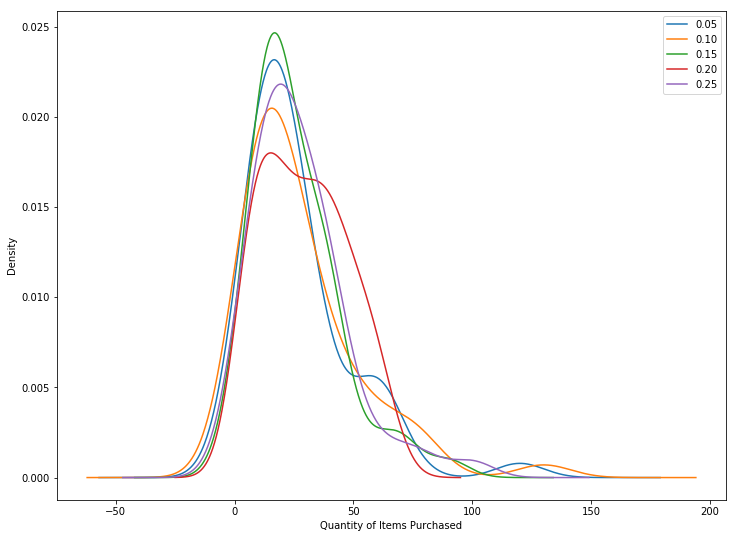

In [237]:
fig, ax = plt.subplots(1, 1, figsize=(12,9))
for i in data.columns:
    data[i].plot(kind='density')
plt.legend()
plt.xlabel('Quantity of Items Purchased')
fig.show()

In [238]:
# One-way ANOVA test
stats.f_oneway(data['0.05'], data['0.10'], data['0.15'], data['0.20'], data['0.25'])

F_onewayResult(statistic=0.22583337048873584, pvalue=0.92379289841810175)

**Analyze Results**

Our F-statistic of 0.2258 suggests the between-groups variance is roughly 1/4 of the within-group variance. We fail to reject the null hypothesis of equal mean values  due to the p value being > 0.05. 

#### Conclusion

These results aren't surprising considering the density plots of our samples. They are visually close to identical so our recommendation is to stick with low levels of discounts as there is no evidence to say that increasing the discount level will increase the quantity bought, so it just reduces the revenue earned.

## Hypothesis Testing
### Is the business seasonal?
  * *Helpful Links*:

  * *Data Needed*:
    * Month
    * Year
    * Total Revenue

In [313]:
# Get data
orders = get_table_data(con, 'Order')
details = get_table_data(con, 'OrderDetail')
# Drop unwanted calumns
orders = orders.drop(['CustomerId', 'EmployeeId', 'RequiredDate', 'ShippedDate', 'ShipVia', 'Freight', 'ShipName', 'ShipAddress', 'ShipCity', 'ShipRegion', 'ShipPostalCode', 'ShipCountry'], axis=1)
details = details.drop(['Id'], axis=1)

# Data Manipulation
orders['OrderDate'] = pd.to_datetime(orders['OrderDate'])
orders['Year'] = orders['OrderDate'].dt.year
orders['Month'] = orders['OrderDate'].dt.month
details['Revenue'] = details['UnitPrice'] * details['Quantity'] * (1 - details['Discount'])
details = details.drop(['UnitPrice', 'Quantity', 'Discount'], axis=1)


2019-06-07 15:44:35,046 INFO sqlalchemy.engine.base.Engine SELECT * FROM 'Order'
2019-06-07 15:44:35,047 INFO sqlalchemy.engine.base.Engine ()
2019-06-07 15:44:35,055 INFO sqlalchemy.engine.base.Engine SELECT * FROM 'OrderDetail'
2019-06-07 15:44:35,056 INFO sqlalchemy.engine.base.Engine ()


#### Data Exploration

Now we have all the data we need to run an expirment. We'll need to merge the two DataFrames but first we'll look at a bar graph to see if there is any visual evidence to our claim.

Text(0.5, 1.0, 'Number of Orders by Month')

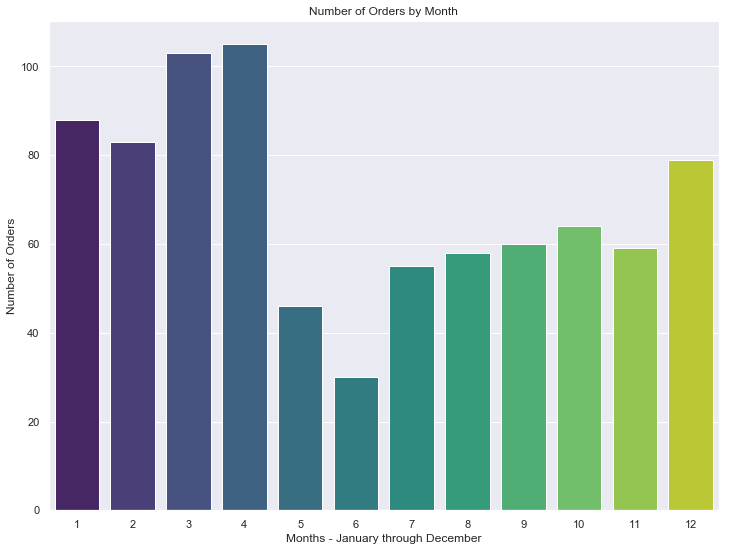

In [339]:
orders_by_month = pd.DataFrame(orders.Month.value_counts())
orders_by_month.sort_index(inplace=True)

# plt.figure(figsize=(12,9))
# sns.set_palette(sns.color_palette("Blues_d"))
# sns.set(rc={"figure.figsize": (12,9)}, palette='viridis')
# sns.set_palette('viridis')

sns.barplot(x=orders_by_month.index, y=orders_by_month['Month'], palette='viridis')
# plt.bar(orders_by_month.index, orders_by_month['Month'])
plt.xlabel('Months - January through December')
plt.ylabel('Number of Orders')
plt.title('Number of Orders by Month')

There does seem to ba seasonality to the number of orders placed but that doesn't necessarily mean that revenues are higher in any given period. Our next step is to join our two DataFrames so we can access all the data we need in one DataFrame.

In [315]:
details['Id'] = details['OrderId']
details.drop(['OrderId'], axis=1, inplace=True)
result = pd.merge(orders, details, how='inner', on='Id')
result.head()

,Id,OrderDate,Year,Month,ProductId,Revenue
0,10248,2012-07-04,2012,7,11,168.0
1,10248,2012-07-04,2012,7,42,98.0
2,10248,2012-07-04,2012,7,72,174.0
3,10249,2012-07-05,2012,7,14,167.4
4,10249,2012-07-05,2012,7,51,1696.0


Text(0.5, 1.0, 'Revenue by Month')

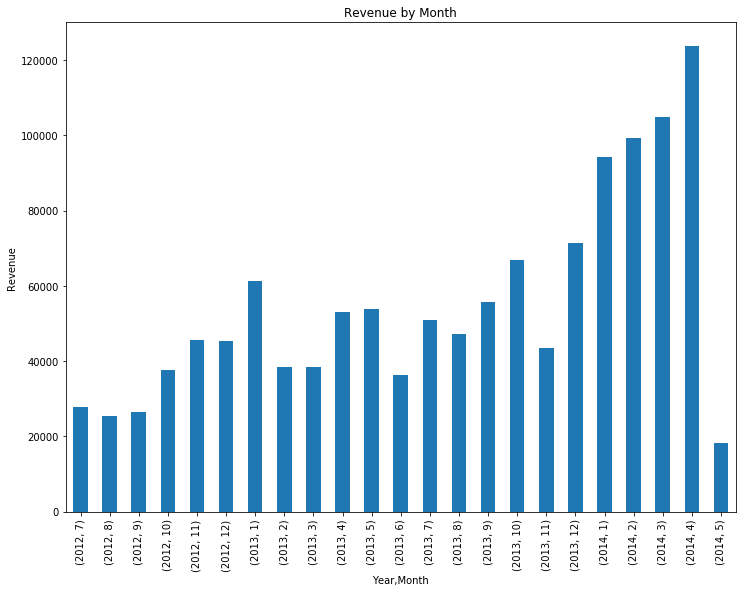

In [316]:
plt.figure(figsize=(12,9))
result.groupby(['Year', 'Month'])['Revenue'].sum().plot(kind='bar')
plt.ylabel('Revenue')
plt.title('Revenue by Month')

Looking at the results of revenue per month, we see there is a general trend of revenue growth. To make sure we aren't just capturing this overal growth, we'll calculate a regression line for the growth month over month and run ANOVA to analyze the variance between the projected revenue and the actual revenue.

Additionally, May 2014 seems unusually low. I'll check to make sure that the whole month's sales were included and that the tracking didn't get cut off mid month.

#### Scrubbing

In [317]:
result.loc[(result['Year'] == 2014) & (result['Month'] == 5)]['OrderDate'].value_counts()

2014-05-06    32
2014-05-05    12
2014-05-01    10
2014-05-04     5
Name: OrderDate, dtype: int64

There are only four days in which orders were placed with the last day being the 6th of the month. Most likely they stopped collecting data on that day, so we don't have the whole month's data to work with. We'll drop any observations that was in that month.

In [318]:
unwanted_rows = result[(result['Year'] == 2014) & (result['Month'] == 5)]
df = pd.concat([result, unwanted_rows])
df.drop_duplicates(keep=False, inplace=True)
unwanted_rows.OrderDate.value_counts()

df.loc[(df['Year'] == 2014) & (df['Month'] == 5)]['OrderDate'].value_counts()


Series([], Name: OrderDate, dtype: int64)

In [319]:
# add a season column to later sort by
seasons = {1: 'Winter',
          2: 'Winter',
          3: 'Spring',
          4: 'Spring',
          5: 'Spring',
          6: 'Summer',
          7: 'Summer',
          8: 'Summer',
          9: 'Fall',
          10: 'Fall',
          11: 'Fall',
          12: 'Winter'}
df['Season'] = df['Month'].map(seasons)
pd.DataFrame(df.groupby(['Year', 'Season'])['Revenue'].sum())


Revenue
Year Season             
2012 Fall    109497.1700
     Summer   53347.1700
     Winter   45239.6300
2013 Fall    165912.2775
     Spring  145361.4625
     Summer  134671.3300
     Winter  171140.1335
2014 Spring  228652.8375
     Winter  193637.3980

In [320]:
# group Revenue by Year and Month
revenue = pd.DataFrame(df.groupby(['Year', 'Month'])['Revenue'].sum())
# add a numeric index for regression
revenue.reset_index(inplace=True)

# regression model
from sklearn.linear_model import LinearRegression

from statsmodels.api import OLS
reg = OLS(revenue['Revenue'].reshape(-1, 1),np.array(revenue.index).reshape(-1, 1)).fit()

reg.summary()

/Users/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     236.4
Date:                Fri, 07 Jun 2019   Prob (F-statistic):           6.66e-13
Time:                        15:44:40   Log-Likelihood:                -246.58
No. Observations:                  22   AIC:                             495.2
Df Residuals:                      21   BIC:                             496.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          4880.3689    317.391     15.377      0.000    4220.318    5540.420
==============================================================================
Omnibus:                        0.940   Durbin-Watson:                   0.531
Prob(Omnibus):                  0.625   Jarque-Bera (JB):                0.896
Skew:                          -0.413   Prob(JB):                        0.639
Kurtosis:                       2.456   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now that we have our regression line and it is highly predictive of the data (there has been linear growth in the business), we'll use that to calculate the variance. Then we'll group the variances of each individual month into season and use that dataset to run our ANOVA test.

In [321]:
revenue['Season'] = revenue['Month'].map(seasons)
revenue['Variance'] = revenue['Revenue'] - reg.predict(revenue.index)
revenue.head()

,Year,Month,Revenue,Season,Variance
0,2012,7,27861.895,Summer,27861.895000
1,2012,8,25485.275,Summer,20604.906108
2,2012,9,26381.400,Fall,16620.662215
3,2012,10,37515.725,Fall,22874.618323
4,2012,11,45600.045,Fall,26078.569431


In [322]:
spring = []
summer = []
fall = []
winter = []
for index, row in revenue.iterrows():
    if row['Season'] == 'Spring':
        spring.append(row['Variance'])
    elif row['Season'] == 'Summer':
        summer.append(row['Variance'])
    elif row['Season'] == 'Fall':
        fall.append(row['Variance'])
    elif row['Season'] == 'Winter':
        winter.append(row['Variance'])

spring = pd.DataFrame(data=spring, columns=['Spring'])
summer = pd.DataFrame(data=summer, columns=['Summer'])
fall = pd.DataFrame(data=fall, columns=['Fall'])
winter = pd.DataFrame(data=winter, columns=['Winter'])

# One-way ANOVA test
stats.f_oneway(spring, summer, fall, winter)

F_onewayResult(statistic=array([ 0.3051157]), pvalue=array([ 0.8213299]))

#### Conclusion

With an F-statistic of `0.3051`, we know that most of the variation in the dataset is within the seasons and not between them. A large p-value of `0.8213` indicates that there isn't enough statistical proof to indicate that the there is a difference in revenue between the seasons. 

### Does supply region effect the reoder level of a product?

In [365]:
# Import supplier data
supplier_df = get_table_data(con, 'Supplier')

# Drop unneeded columns
supplier_df.drop(['ContactName', 'ContactTitle', 'Address', 'City', 'PostalCode', 'Country', 'Phone', 'Fax', 'HomePage'], axis=1, inplace=True)
supplier_df.rename(columns={'CompanyName':'SupplierName'}, inplace=True)

# import product data
product_df = get_table_data(con, 'Product')

# Drop unneeded columns
product_df.drop(['CategoryId', 'QuantityPerUnit', 'UnitPrice', 'UnitsInStock', 'UnitsOnOrder', 'Discontinued'], axis=1, inplace=True)

# Merge and cleanup DataFrames
df = supplier_df.merge(product_df, left_on='Id', right_on='SupplierId', how='left',suffixes=('', '_p'))
df.drop(['SupplierId'], axis=1, inplace=True)
df.rename(columns={'Id': 'SupplierId', 'Id_p': 'ProductId'}, inplace=True)
df.head()

2019-06-08 11:31:09,570 INFO sqlalchemy.engine.base.Engine SELECT * FROM 'Supplier'
2019-06-08 11:31:09,572 INFO sqlalchemy.engine.base.Engine ()
2019-06-08 11:31:09,576 INFO sqlalchemy.engine.base.Engine SELECT * FROM 'Product'
2019-06-08 11:31:09,577 INFO sqlalchemy.engine.base.Engine ()


,SupplierId,SupplierName,Region,ProductId,ProductName,ReorderLevel
0,1,Exotic Liquids,British Isles,1,Chai,10
1,1,Exotic Liquids,British Isles,2,Chang,25
2,1,Exotic Liquids,British Isles,3,Aniseed Syrup,25
3,2,New Orleans Cajun Delights,North America,4,Chef Anton's Cajun Seasoning,0
4,2,New Orleans Cajun Delights,North America,5,Chef Anton's Gumbo Mix,0


In [368]:
df.ReorderLevel.value_counts()

0     24
25    12
15    10
30     8
20     8
5      8
10     7
Name: ReorderLevel, dtype: int64

In [374]:
pd.DataFrame(df.groupby(['Region'])['ProductId'].count()) #.sum().plot(kind='bar')

,ProductId
Region,
British Isles,7
Eastern Asia,6
NSW,3
North America,16
Northern Europe,9
Scandinavia,6
South America,1
South-East Asia,3
Southern Europe,7


### Hypothesis #3

## Conclusion

## Future Work

## Recap

- Introduction
- Discount Effect
  - Get Data
  - Explore + Clean
  - Experimental Design
    - Check Assumptions
    - Get Samples
    - T Test
    - ANOVA
  - Conclusion
- Hypothesis Testing
- Conclusion
- Future Work
- Recap